In [1]:
import pandas as pd;
from sklearn.covariance import empirical_covariance
import math
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score
import graphviz
df = pd.read_csv("../crawler/data.csv")

In [2]:
# Data cleaning
df.fillna(0, inplace=True)
df["# Churn (over 5)"] = np.where((df["# Churn (over 5)"] != 0),df["# Churn (over 5)"]-df["# Churn (over 3)"],df["# Churn (over 5)"])
df["# Churn (over 3)"] = np.where((df["# Churn (over 3)"] != 0),df["# Churn (over 3)"]-df["# Churn"],df["# Churn (over 3)"])
df["# Lines added (over 5)"] = np.where((df["# Lines added (over 5)"] != 0),df["# Lines added (over 5)"]-df["# Lines added (over 3)"],df["# Lines added (over 5)"])
df["# Lines added (over 3)"] = np.where((df["# Lines added (over 3)"] != 0),df["# Lines added (over 3)"]-df["# Lines added"],df["# Lines added (over 3)"])
df["# Lines removed (over 5)"] = np.where((df["# Lines removed (over 5)"] != 0),df["# Lines removed (over 5)"]-df["# Lines removed (over 3)"],df["# Lines removed (over 5)"])
df["# Lines removed (over 3)"] = np.where((df["# Lines removed (over 3)"] != 0),df["# Lines removed (over 3)"]-df["# Lines removed"],df["# Lines removed (over 3)"])
df["# Contributors committed (over 5)"] = np.where((df["# Contributors committed (over 5)"] != 0),df["# Contributors committed (over 5)"]-df["# Contributors committed (over 5)"],df["# Contributors committed (over 5)"])

In [3]:
# Clusteranalyse
# Covariance matrix, remove correlating stuff: over time data and lines removed, added etc
s = df[["# Lines added","# Lines added (over 3)","# Lines added (over 5)","# Lines removed","# Lines removed (over 3)","# Lines removed (over 5)","# Hunks count","# Files committed","# Contributors committed (over 3)","# Contributors committed (over 5)"]].copy()
cov = empirical_covariance(s)
for i, row in enumerate(cov):
    for j, cell in enumerate(row):
        if not math.isnan(cell) and i != j:
            p = s[s.columns[i]].corr(s[s.columns[j]])
            if (abs(p) > 0.3):
                print(s.columns[i] + " to "+ s.columns[j] + ": "+ str(p))

# Lines added to # Lines removed: 0.440217859033384
# Lines added (over 3) to # Lines removed (over 3): 0.3625800475842895
# Lines added (over 5) to # Lines removed (over 5): 0.3538734193594511
# Lines removed to # Lines added: 0.440217859033384
# Lines removed (over 3) to # Lines added (over 3): 0.3625800475842895
# Lines removed (over 5) to # Lines added (over 5): 0.35387341935945116
# Hunks count to # Contributors committed (over 3): 0.3425247306288411
# Contributors committed (over 3) to # Hunks count: 0.3425247306288411


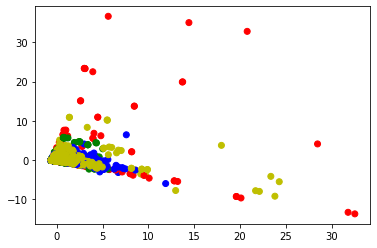

In [4]:
# Scikit learn pca, components_ plotting on 2D the first two elements
sc = StandardScaler()
pca = PCA()
r = pca.fit_transform(sc.fit_transform(s))
plt.scatter(r[:,0],r[:,1], c=["g" if x < 260 else "b" if x < 1150 else "y" if x < 8300 else "r" for x in df["SQALE"]])
plt.show()

0.1548357224953469
-0.09244153634628507
-0.07529494007308239
0.38057387977408463
0.9032693818133216
0.0015237448953549536
0.0301241347221798
0.008192414653470315
0.010108331209123592
0.0


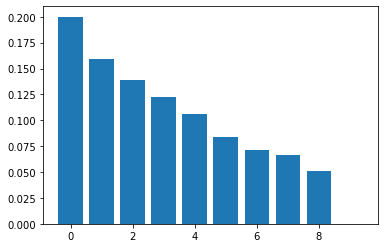

In [5]:
# and explained_variance_ as histogram good if variance ~60%
plt.bar(np.arange(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_)
for n in pca.components_:
    print(n[7])

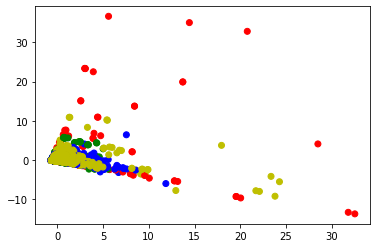

0.4395375713165261
-0.04300684095221265
0.09400024170291854
0.47952399168939686
0.017539527114227977
-0.30377818946387347
0.012000435820664174
0.65439699572897
0.08803595148204274
0.19354389773089078
0.0


<BarContainer object of 11 artists>

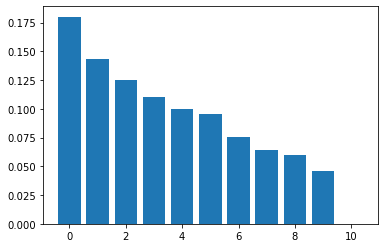

In [6]:
# introduce feature random variable and try it again
t = s.copy()
scr = StandardScaler()
pcar = PCA()
t["random"] = np.random.normal(0, 50, s.shape[0])
r2= pcar.fit_transform(scr.fit_transform(t))
plt.scatter(r2[:,0],r2[:,1], c=["g" if x < 260 else "b" if x < 1150 else "y" if x < 8300 else "r" for x in df["SQALE"]])
plt.show()
for n in pcar.components_:
    print(n[8])
# and explained_variance_ as histogram good if variance ~60%
plt.bar(np.arange(len(pcar.explained_variance_ratio_)),pcar.explained_variance_ratio_)

In [7]:
# SQALE PRedcition over all better adding % actually insanely helps the accuracy
y = df["SQALE"] #df["Complexity"] 
X = df[["# Lines added","# Lines added (over 3)","# Lines added (over 5)","# Lines removed","# Lines removed (over 3)","# Lines removed (over 5)","# Hunks count","# Files committed","# Contributors committed (over 3)","# Contributors committed (over 5)", "% Comments", "% Duplicated lines"]].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [18]:
# decision tree
dtree = tree.DecisionTreeClassifier(max_depth=18)
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)

print('Accuracy: ' + str(accuracy_score(y_test, y_pred))+" with depth of "+str(dtree.get_depth()))

Accuracy: 0.519406392694064 with depth of 18


In [19]:
# tree view
dot_data = tree.export_graphviz(dtree, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("sqale.png")

'sqale.png.pdf'

In [20]:
# random forest
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))

Accuracy: 0.5970319634703196


In [73]:
# linear regression
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print('MAE: ' + str(mean_absolute_error(y_test, y_pred)))
print('MSE: ' + str(mean_squared_error(y_test, y_pred)))
print('R2: ' + str(r2_score(y_test, y_pred)))

MAE: 1958.7575201671157
MSE: 7398060.3459403515
R2: 0.5777867937661554


In [21]:
# Overtall predictions greatly increase by using code centric metrics
# 0.6 seems like a hard limit on how accurate a prediction can be
# follow up use differences in values between commits